# Comment analysis

In [2]:
# import libraries
from datetime import datetime

import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import math


d:\Documentos\camilo\Maestria\TESIS\tiktok_analytics\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the pre-trained model for sentiment analysis
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

Device set to use cpu


In [4]:
def classify_feeling_videos(row) -> dict:
    """
    Classifies the sentiment of a review and returns the score, classification, percentage and date of the review.
    
    """
    retry_flag = True
    retries = 4
    max_chars = 2113
    type_target = None 
    while retry_flag and retries > 0:
        try:
            if pd.isnull(row['video_trasncription']):
                video_transcription = row['video_description']
                type_target = 'description'
            else:
                video_transcription = row['video_trasncription'][0:max_chars]
                type_target = 'transcription'
            # Use the Hugging Face pre-trained model
            result = sentiment_analyzer(video_transcription)
            retry_flag = False
        except RuntimeError:
            retry_flag = True
            retries -= 1
            max_chars -= 100
    
    if retry_flag == True:
        if type_target == 'description':
            return {'score': None, 'clasification': '#ERROR', 'percentage': None, 'date': None}
        else:
            try:
                result = sentiment_analyzer(row['video_description'])
            except RuntimeError:
                return {'score': None, 'clasification': '#ERROR', 'percentage': None, 'date': None}
    

    # Get the label and score
    label = result[0]['label']
    percentage = result[0]['score']
    parsed_date = datetime.strptime(row['video_timestamp'], "%Y-%m-%dT%H:%M:%S")
    
    # Classification according to the label
    if label == '5 stars':
        clasification = 'Excellent'
        score = 5
    elif label == '4 stars':
        clasification = 'Good'
        score = 4
    elif label == '3 stars':
        clasification = 'Neutral'
        score = 3
    elif label == '2 stars':
        clasification = 'Bad'
        score = 2
    elif label == '1 star':
        clasification = 'Terrible'
        score = 1
    elif label == '0 stars':
        clasification = 'Terrible'
        score = 0
    else:
        clasification = '#ERROR'
        score = None
    
    return {'score': score, 'clasification': clasification, 'percentage': percentage, 'date': parsed_date, 'video_id': row['video_id']}


In [5]:
def visualize_rating_percentages(df):
    """
    Create visualizations for rating percentages by month and average rating over time.
    
    Parameters:
    df: DataFrame with index=score_month and columns 1, 2, 3, 4, 5, total, average_rating
    
    Returns:
    None (displays plots)
    """
    # Make a copy to avoid modifying the original dataframe
    df_copy = df.copy()
    
    # Calculate percentages for each rating
    for rating in range(1, 6):
        df_copy[f"{rating}_percent"] = (df_copy[rating] / df_copy['total'] * 100).round(2)
    
    # Get months from index
    months = df_copy.index
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # 1. Stacked bar chart - Rating distribution by month
    x = np.arange(len(months))
    width = 0.8
    
    # Get percentage data for each rating
    rating_percentages = [df_copy[f"{rating}_percent"].values for rating in range(1, 6)]
    
    # Colors for ratings
    colors = ['#FF9999', '#FFD699', '#FFFF99', '#99FF99', '#9999FF']
    
    # Create the stacked bar chart
    bottom = np.zeros(len(months))
    for i, data in enumerate(rating_percentages):
        label = f"{i+1} Star"
        ax1.bar(x, data, width, bottom=bottom, label=label, color=colors[i])
        bottom += data
    
    ax1.set_title('Rating Distribution by Month', fontsize=14)
    ax1.set_ylabel('Percentage (%)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(months, rotation=45, ha='right')
    ax1.set_xlabel('')
    ax1.legend(title='Rating')
    
    # 2. Line chart for average rating over time
    ax2.plot(x, df_copy['average_rating'], marker='o', linewidth=2, color='#3366CC')
    
    # Add data labels
    for i, val in enumerate(df_copy['average_rating']):
        ax2.text(i, val + 0.05, f"{val}", ha='center', va='bottom', fontsize=10)
    
    ax2.set_title('Average Rating by Month', fontsize=14)
    ax2.set_ylabel('Average Rating')
    ax2.set_xticks(x)
    ax2.set_xticklabels(months, rotation=45, ha='right')
    ax2.set_ylim(min(df_copy['average_rating'])-0.5, max(df_copy['average_rating'])+0.5)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add horizontal line at rating 4.0 for reference
    ax2.axhline(y=4.0, color='r', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualization - Heatmap of percentage distribution using imshow
    fig, ax = plt.subplots(figsize=(18, 6))
    
    # Prepare heatmap data
    heatmap_data = np.array([df_copy[f"{i}_percent"].values for i in range(1, 6)])
    
    # Create heatmap using imshow
    im = ax.imshow(heatmap_data, cmap='YlGnBu')
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Percentage (%)')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(months)))
    ax.set_xticklabels(months, rotation=45, ha='right')
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels([f"{i}★" for i in range(1, 6)])
    
    # Add text annotations to heatmap
    for i in range(5):
        for j in range(len(months)):
            text = ax.text(j, i, f"{heatmap_data[i, j]:.1f}%",
                          ha="center", va="center", color="black")
    
    plt.title('Percentage of Each Rating by Month', fontsize=14)
    plt.tight_layout()
    plt.show()

In [6]:
def process_dataframe_in_parallel(df, process_func, num_partitions=3):
    """
    Process a large dataframe in parallel using threads.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe to process
    process_func : function
        The function to apply to each partition (should take a dataframe and return a dataframe)
    num_partitions : int
        Number of partitions to split the dataframe into
        
    Returns:
    --------
    pandas.DataFrame
        The concatenated result of processing all partitions
    """
    # Calculate partition size
    partition_size = math.ceil(len(df) / num_partitions)
    
    # Function to process a partition
    def process_partition(partition_df):
        return partition_df.apply(process_func, axis=1)
    
    # Split dataframe into partitions
    partitions = [df.iloc[i:i + partition_size] for i in range(0, len(df), partition_size)]
    
    # Process partitions in parallel
    results = []
    with ThreadPoolExecutor(max_workers=num_partitions) as executor:
        # Submit all partitions to the executor
        future_results = [executor.submit(process_partition, partition) for partition in partitions]
        
        # Collect results as they complete
        for future in future_results:
            results.append(future.result())
    
    # Concatenate results
    return pd.concat(results)

In [7]:
# Load the Excel file into a DataFrame
df_videos = pd.read_excel(r"D:\Documentos\camilo\Maestria\TESIS\TikTokAnalyticsProject\output\video_info_03-28-2025_0811_Galan_V2.xlsx",sheet_name='videos_data', dtype=str)


### Analysis for Videos

In [8]:
display(df_videos.head())

,video_id,hashtag,video_timestamp,video_locationcreated,video_diggcount,video_sharecount,video_commentcount,video_playcount,video_description,video_is_ad,author_username,author_name,author_followercount,author_heartcount,author_videocount,author_diggcount,author_verified,trasncription_lang,video_trasncription,mining_date
0,7374919036544601349,carlosfernandogalan,2024-05-30T17:12:32,CO,4390,146,494,182900,"Hoy, después de 7 años, habilitamos un tercer ...",False,carlosfgalan,Carlos Fernando Galán,205600,2800000,917,290,True,eng-US,"Well, I'm with Orlando Molano here at 146 wit...",03-28-2025_0811
1,7274743338903833862,carlosfernandogalan,2023-09-03T18:19:39,CO,284,7,62,16300,Que opinan de Molano? #colombiavota #parati #b...,False,jssr63,JSSR,4603,197500,26,312,False,eng-US,"During his administration, will it actively pr...",03-28-2025_0811
2,7478350483309088055,carlosfernandogalan,2025-03-05T10:39:25,CO,1651,44,447,27900,La ley no es una opción. La Constitución no es...,False,carlosfgalan,Carlos Fernando Galán,205600,2800000,917,290,True,eng-US,The law is not an option The constitution is n...,03-28-2025_0811
3,7428005105493904646,carlosfernandogalan,2024-10-20T18:33:43,CO,6429,161,536,306400,"Mañana empieza la COP16 en Cali, un hito impor...",False,carlosfgalan,Carlos Fernando Galán,205600,2800000,917,290,True,eng-US,"We are in the Sumapaz wasteland, blessed by th...",03-28-2025_0811
4,7317679974952045830,carlosfernandogalan,2023-12-28T11:15:45,CO,25,0,0,829,#ladiabla #fyp,False,carlosfernandodel6,Carlos Fernando Delg,61,993,13,77800,False,spa-ES,"La mala influencia, y eso te gustó, eres niña ...",03-28-2025_0811


In [9]:
# df_test = df_videos.sample(300)
# df_sentiment = df_test.apply(classify_feeling_videos, axis=1)

In [10]:
df_videos = df_videos.drop_duplicates(subset=['video_id']).dropna()

In [11]:
len(df_videos.index)

468

In [12]:
df_sentiment = process_dataframe_in_parallel(df_videos, classify_feeling_videos, num_partitions=4)

Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors


In [13]:
# df_sentiment = df_test.apply(classify_feeling_videos, axis=1)

In [14]:
# Apply sentiment analysis
# df_sentiment = df_videos.apply(classify_feeling_videos, axis=1)

In [15]:
df_sentiment = pd.json_normalize(df_sentiment)

In [16]:
display(df_sentiment.head())

,score,clasification,percentage,date,video_id
0,1,Terrible,0.507345,2024-05-30 17:12:32,7374919036544601349
1,2,Bad,0.241560,2023-09-03 18:19:39,7274743338903833862
2,1,Terrible,0.587643,2025-03-05 10:39:25,7478350483309088055
3,5,Excellent,0.719721,2024-10-20 18:33:43,7428005105493904646
4,2,Bad,0.346827,2023-12-28 11:15:45,7317679974952045830


In [17]:
counts = df_sentiment["clasification"].value_counts()

print(counts)

clasification
Terrible     153
Excellent    116
Good         102
Bad           72
Neutral       25
Name: count, dtype: int64


In [18]:
percentage = (counts/len(df_sentiment))*100
print(percentage)

clasification
Terrible     32.692308
Excellent    24.786325
Good         21.794872
Bad          15.384615
Neutral       5.341880
Name: count, dtype: float64


In [19]:
resumen = pd.DataFrame({'counts': counts,     'percentage': percentage })

<Axes: ylabel='percentage'>

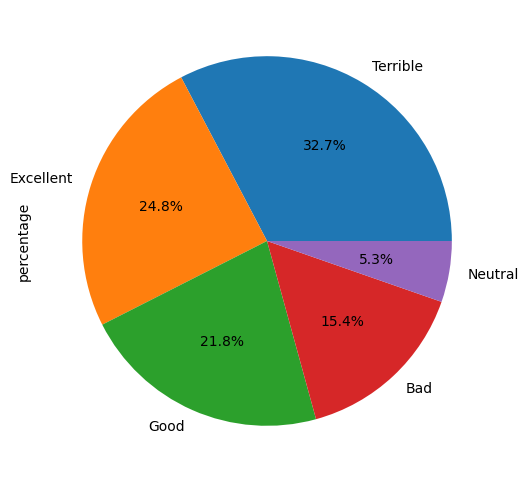

In [20]:
resumen['percentage'].plot.pie(autopct='%1.1f%%', figsize=(6, 6), labels=resumen.index)

In [21]:
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])

<Axes: title={'center': 'Sentiment Analysis over time'}, xlabel='Date', ylabel='Score'>

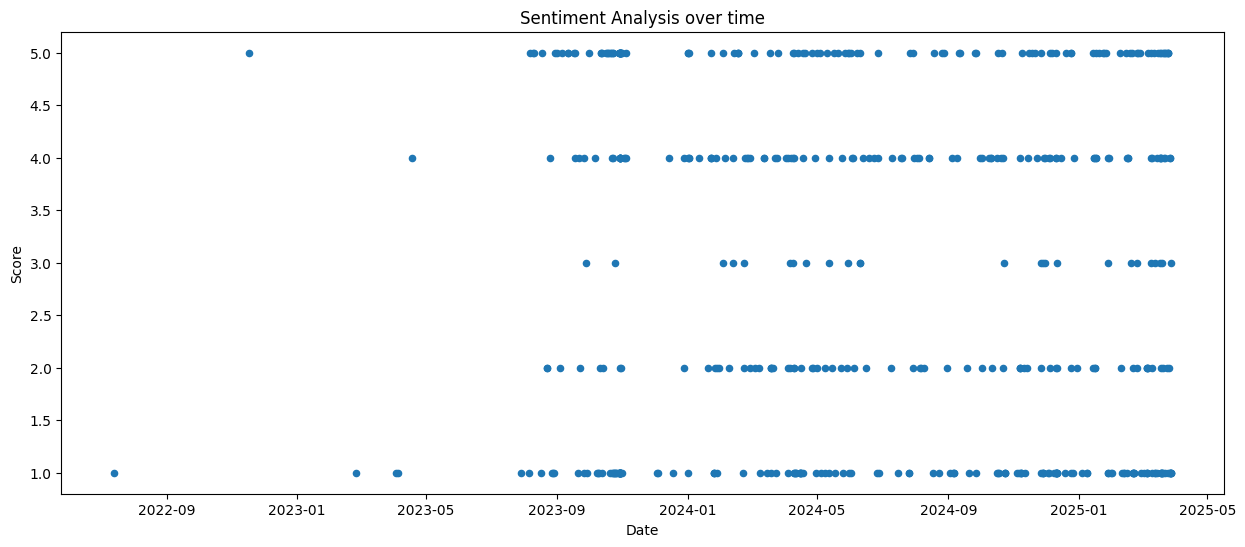

In [22]:
df_sentiment.sort_values(by='date').plot.scatter(x='date', y='score', figsize=(15, 6), title='Sentiment Analysis over time', xlabel='Date', ylabel='Score')

In [23]:
df_sentiment.to_excel(r"results\video_sentiment_analysis_galan_v2.xlsx", index=False)

In [24]:
df_sorted = df_sentiment.sort_values(by='date')

In [25]:
def count_ratings_by_month(df):
    # Make sure the date column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Create a month column
    df['month'] = df['date'].dt.to_period('M')
    
    # Group by month and rate, then count
    result = df.groupby(['month', 'score']).size().unstack(fill_value=0)
    
    # Add a total column
    result['total'] = result.sum(axis=1)

    #Calculate Average
    temp_df = df[['month', 'score']].copy()

    # Group by month and calculate mean
    avg_ratings = temp_df.groupby('month')['score'].mean().round(2)

    result['average_rating'] = avg_ratings
    
    return result

In [26]:
monthly_counts = count_ratings_by_month(df_sorted)

In [27]:
display(monthly_counts)

score,1,2,3,4,5,total,average_rating
month,,,,,,,
2022-07,1,0,0,0,0,1,1.00
2022-11,0,0,0,0,1,1,5.00
2023-02,1,0,0,0,0,1,1.00
2023-04,2,0,0,1,0,3,2.00
2023-07,1,0,0,0,0,1,1.00
2023-08,5,2,0,1,6,14,3.07
2023-09,3,2,1,3,6,15,3.47
2023-10,26,4,1,10,24,65,3.03
2023-11,0,0,0,3,1,4,4.25


<Axes: title={'center': 'Total Ratings by Month'}, xlabel='Month', ylabel='Total Ratings'>

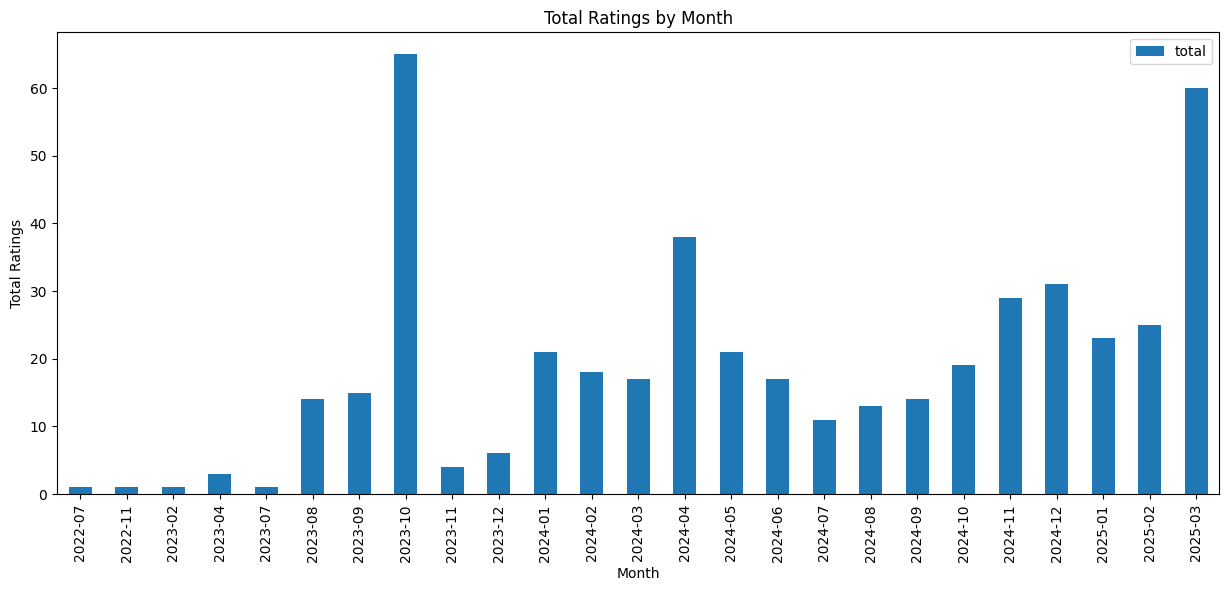

In [28]:
monthly_counts.plot.bar(y='total', figsize=(15, 6), title='Total Ratings by Month', xlabel='Month', ylabel='Total Ratings')

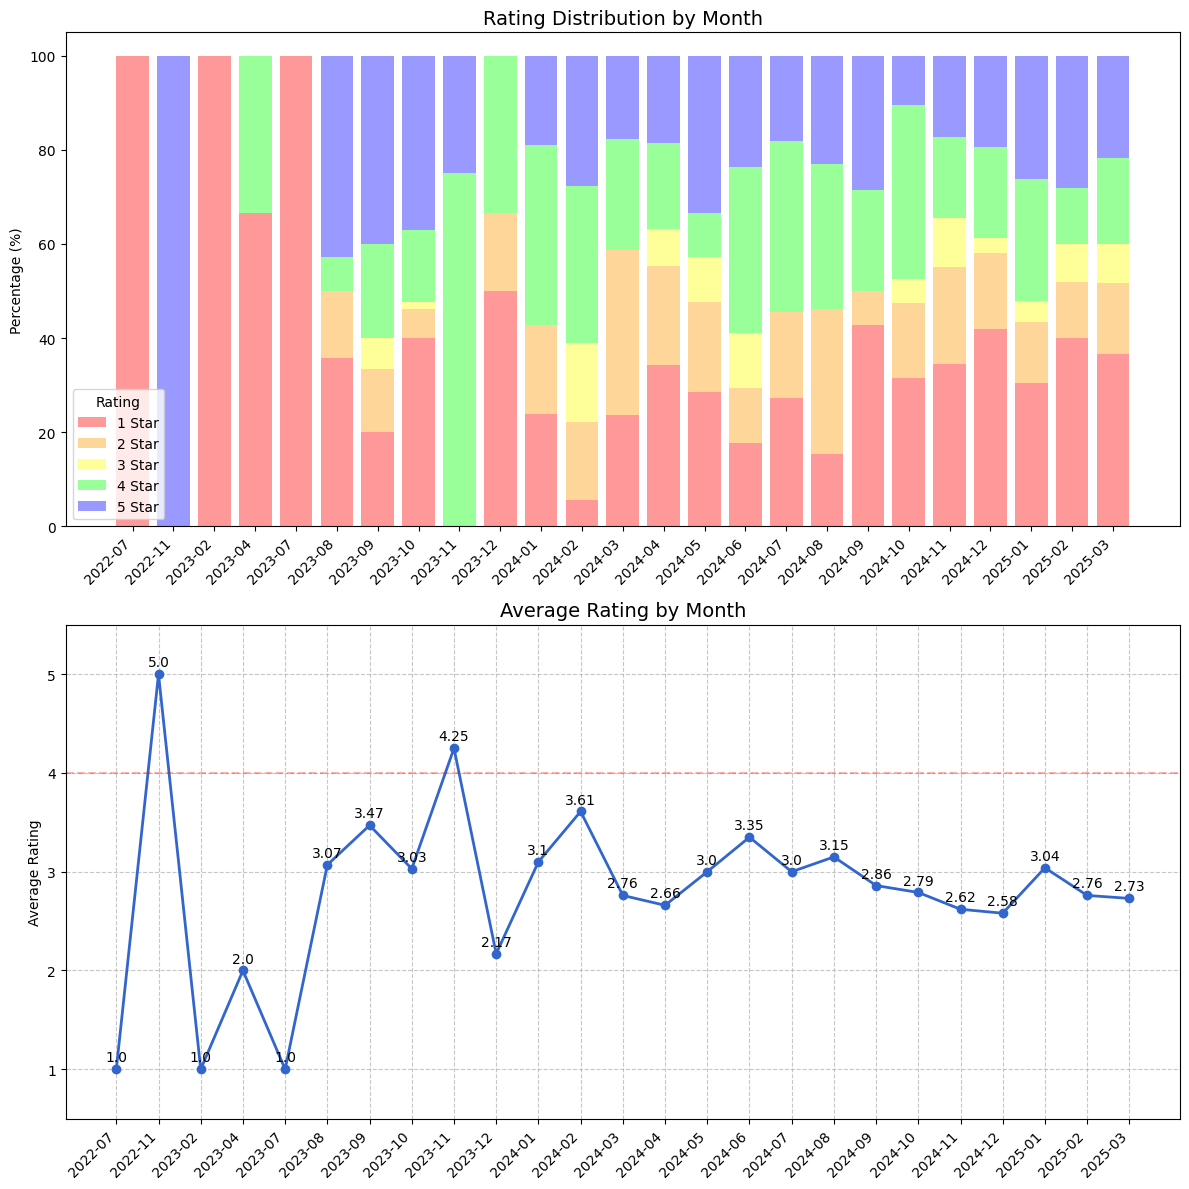

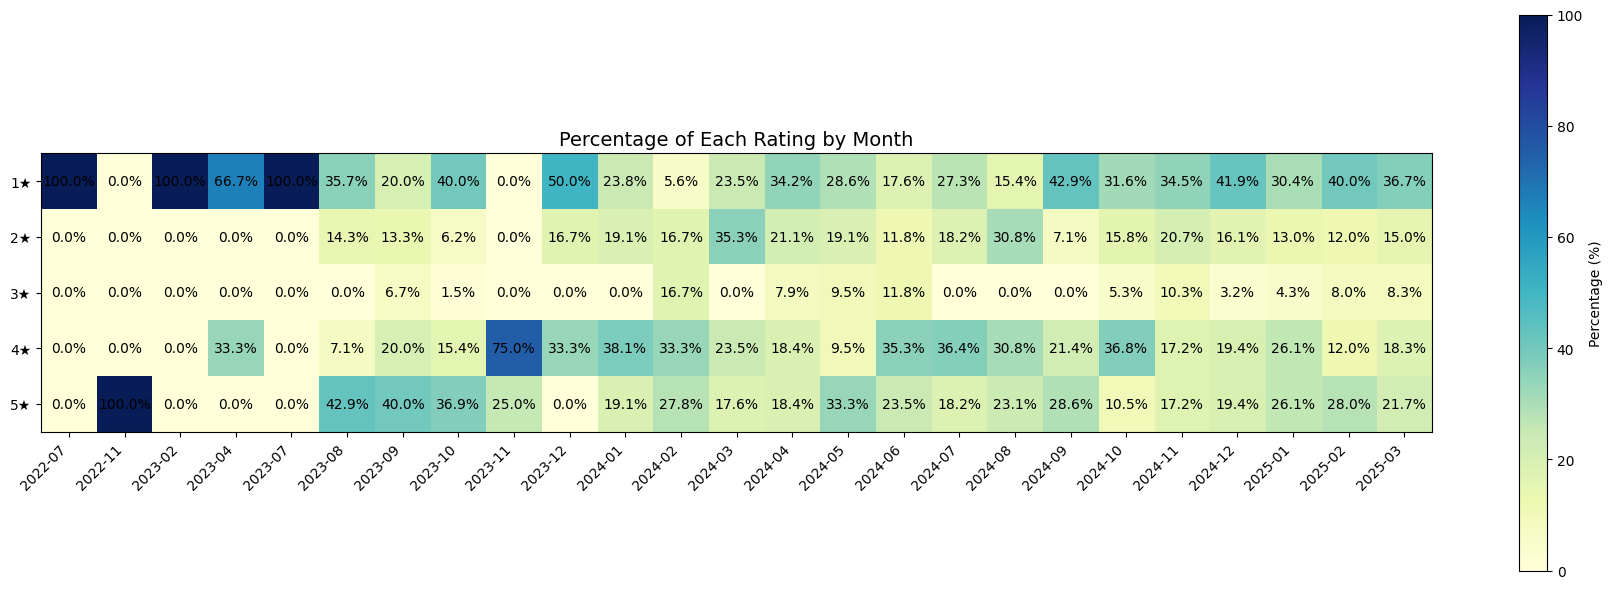

In [29]:
visualize_rating_percentages(monthly_counts)

### Text Classifier

In [30]:
text_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

Device set to use cpu


In [31]:
# test_res = text_classifier("Pension Colombia the responsibility of citizens when an  irresponsible person is elected The response of Carlos  Fernando Galán in the political control debate in over water shortage.  They are more than shameful and irresponsible Words more words less  meant to say I was caught sleeping I was elected governor of Bogotá and  I have no idea of the problems of the capital die upon his arrival in office,  the outgoing administration of Claudia López did  not issue a warning to the short-term water crisis.  I must say that when I arrived at the  junction at the aqueduct meeting they warned us,  they warned us that we would have to take steps to guarantee the  water supply from 2040 onwards from 2040 onwards they did not tell us  anything about 2024 and the situation we were facing at that time already. ",
#     candidate_labels=["security", "subway", "movility", "water", "governance", "environment", "urban planning", "infrastructure"],
# )

In [32]:
# print(test_res)

In [33]:
def classify_main_topic(row, topics = ["security", "subway", "movility", "water", "governance", "environment", "urban planning", "infrastructure"]) -> dict:
    
    
    if pd.isnull(row['video_trasncription']):
        video_transcription = row['video_description']
        type_target = 'description'
    else:
        video_transcription = row['video_trasncription']
        type_target = 'transcription'
        
    # Use the Hugging Face pre-trained model
    result = text_classifier(video_transcription, candidate_labels=topics)
    
    # Get the main label
    label = result['labels'][0]
    score = result['scores'][0]
    
    return {'main_topic': label, 'score': score, 'video_id': row['video_id'], 'date': row['video_timestamp']}


    

In [34]:
# df_test = df_videos.sample(100)

In [35]:
# df_sorted = df_test.apply(classify_main_topic, axis=1, engine='parallel')

In [36]:
df_topics = process_dataframe_in_parallel(df_videos, classify_main_topic, num_partitions=6)

In [37]:
df_topics = pd.json_normalize(df_topics)

In [38]:
display(df_topics.head())

,main_topic,score,video_id,date
0,security,0.354610,7374919036544601349,2024-05-30T17:12:32
1,governance,0.163818,7274743338903833862,2023-09-03T18:19:39
2,environment,0.397363,7478350483309088055,2025-03-05T10:39:25
3,water,0.406695,7428005105493904646,2024-10-20T18:33:43
4,environment,0.566043,7317679974952045830,2023-12-28T11:15:45


In [39]:
df_topics.to_excel(r"results\video_topics_analysis_galan_v2.xlsx", index=False)

In [40]:
# df_topics = pd.read_excel(r"results\video_topics_analysis_galan_v2.xlsx")

In [41]:
df_topics['date'] = pd.to_datetime(df_topics['date'])

In [42]:
def create_topic_visualizations(df_in):
    """
    Create visualizations for topic percentages (total and per month)
    
    Parameters:
    df: DataFrame with columns main_topic, score, video_id, date
    
    Returns:
    None (displays plots)
    """
    df = df_in.copy()

    # Make sure date is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])
    
    # Add month column for grouping
    df['month'] = df['date'].dt.strftime('%Y-%m')
    
    # Figure 1: Total Percentage of Topics
    plt.figure(figsize=(12, 6))
    
    # Count total occurrences of each topic
    topic_counts = df['main_topic'].value_counts()
    total_topics = topic_counts.sum()
    topic_percentages = (topic_counts / total_topics * 100).round(1)
    
    # Sort from highest to lowest
    topic_percentages = topic_percentages.sort_values(ascending=False)
    
    # Get colors - one for each topic
    colors = plt.cm.coolwarm(np.linspace(0, 0.9, len(topic_percentages)))
    
    # Create pie chart
    plt.pie(topic_percentages, labels=None, autopct='%1.1f%%', startangle=90, colors=colors, 
            wedgeprops={'edgecolor': 'white', 'linewidth': 1})
    
    # Add legend outside of pie chart
    plt.legend(topic_percentages.index, loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.title('Total Percentage of Topics', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Figure 2: Percentage of Topics by Month
    # Get topic counts per month
    monthly_topics = df.groupby(['month', 'main_topic']).size().unstack(fill_value=0)
    
    # Calculate percentages for each month
    monthly_percentages = monthly_topics.div(monthly_topics.sum(axis=1), axis=0) * 100
    
    # Sort months chronologically
    monthly_percentages = monthly_percentages.sort_index()
    
    # Plot stacked bar chart
    plt.figure(figsize=(14, 8))
    
    # Get unique topics and sort them by overall frequency
    all_topics = topic_counts.index.tolist()
    
    # Make sure all topics are in the monthly data (fill missing with zeros)
    for topic in all_topics:
        if topic not in monthly_percentages.columns:
            monthly_percentages[topic] = 0
    
    # Reorder columns by overall frequency
    monthly_percentages = monthly_percentages[all_topics]
    
    # Plot stacked bars
    ax = monthly_percentages.plot(kind='bar', stacked=True, figsize=(14, 8), 
                                 colormap='coolwarm', width=0.8)
    
    # Add labels and title
    plt.title('Percentage of Topics by Month', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add percentage labels on bars
    for container in ax.containers:
        ax.bar_label(container, labels=['%.1f%%' % x if x >= 5 else '' for x in container.datavalues], 
                    label_type='center')
    
    plt.tight_layout()
    plt.show()
    
    # Option 3: Topic Trends Over Time (Line Chart)
    plt.figure(figsize=(14, 8))
    
    # Get top N topics for clarity
    top_topics = topic_counts.nlargest(6).index.tolist()
    
    # Plot line for each top topic
    for topic in top_topics:
        if topic in monthly_percentages.columns:
            plt.plot(monthly_percentages.index, monthly_percentages[topic], 
                    marker='o', linewidth=2, label=topic)
    
    plt.title('Trend of Topics Over Time', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Topic')
    
    plt.tight_layout()
    plt.show()

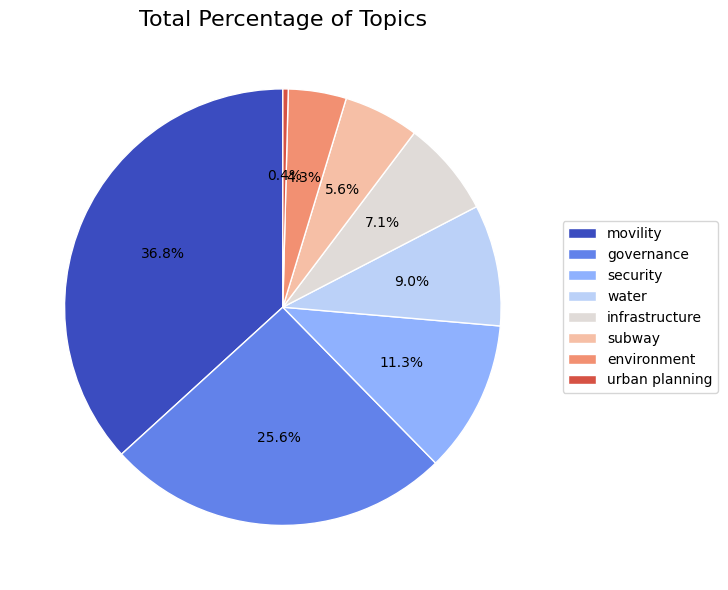

<Figure size 1400x800 with 0 Axes>

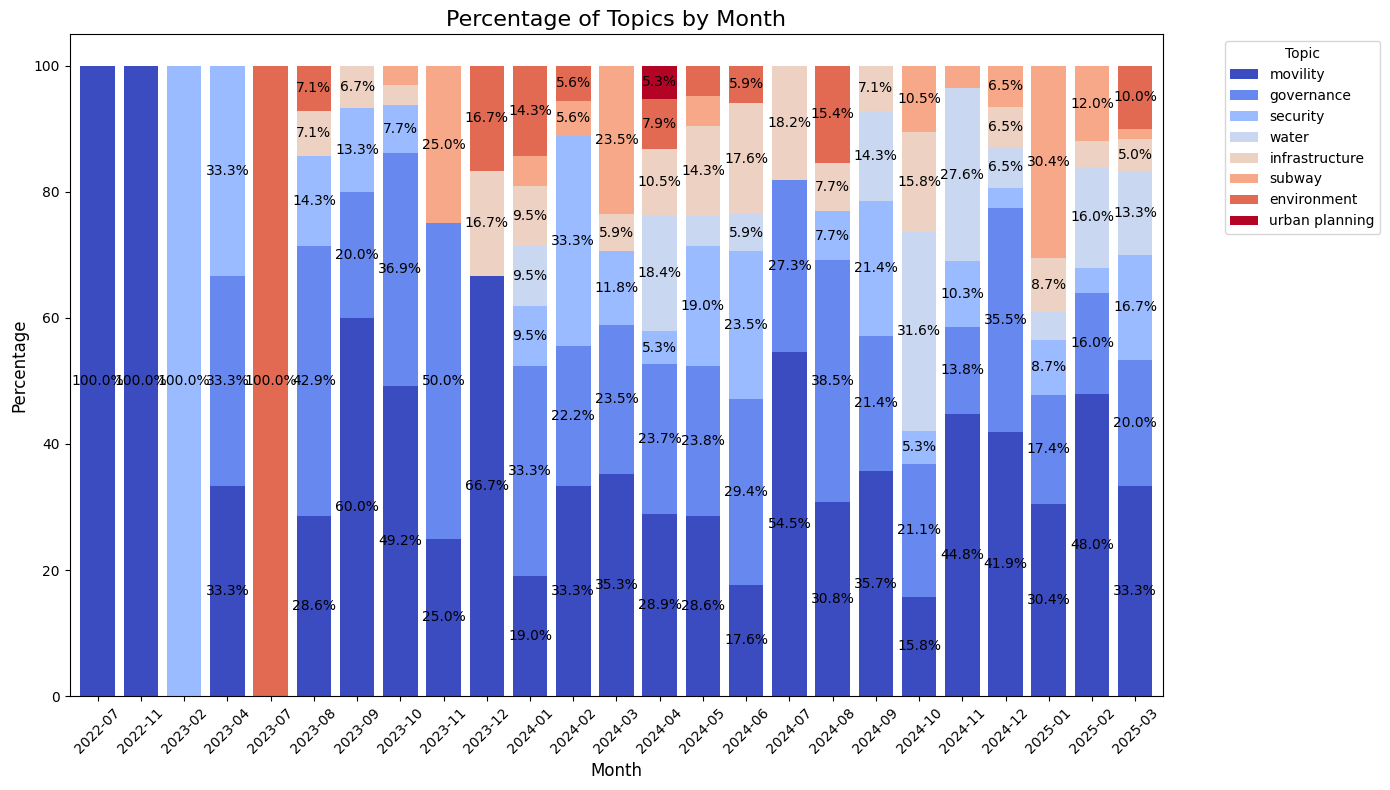

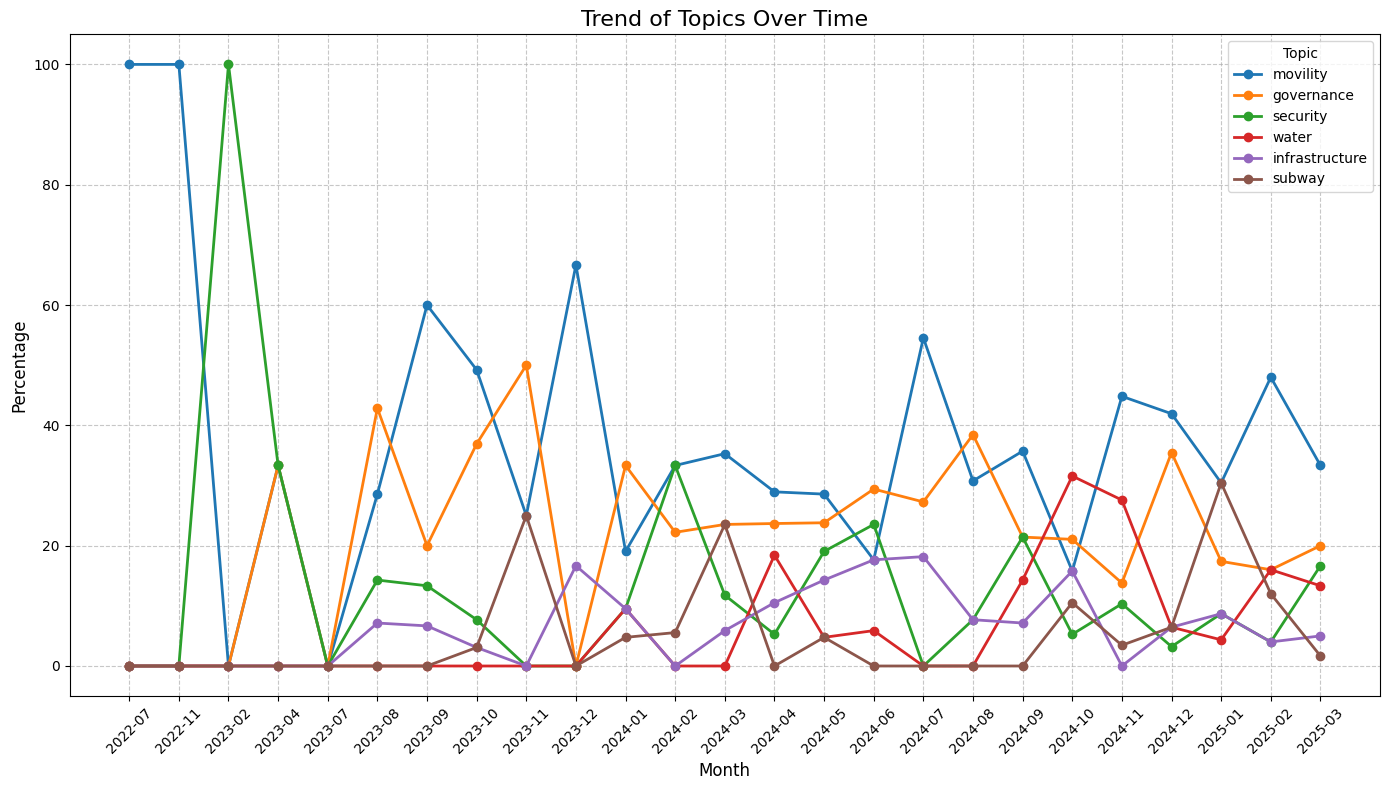

In [43]:
create_topic_visualizations(df_topics)

In [44]:
df_sentiment['Approval'] = df_sentiment['score'].apply(lambda x: 'Approved' if x >= 4 else 'Disapproved' if x <= 2 else 'Neutral')

In [45]:
def approval_by_month(df):
    # Make sure the date column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Create a month column
    df['month'] = df['date'].dt.to_period('M')
    
    # Group by month and Approval status, then count
    result = df.groupby(['month', 'Approval']).size().unstack(fill_value=0)
    
    # Add a total column
    result['total'] = result.sum(axis=1)

    #Calculate percentages
    for rating in ['Approved', 'Disapproved', 'Neutral']:
        result[f"{rating}_percent"] = (result[rating] / result['total'] * 100).round(2)

    # result['approval_percentages'] = approval_percentages
    
    return result

In [46]:
df_approval = approval_by_month(df_sentiment)

In [47]:
invamer_data = {
    'date': ['2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02'],
    'Approved_percent': [54,56,59,53,47,49,50,51,52,49,47,45,44]
}
df_invamer = pd.DataFrame(invamer_data)

In [48]:
display(df_approval.head(100))

Approval,Approved,Disapproved,Neutral,total,Approved_percent,Disapproved_percent,Neutral_percent
month,,,,,,,
2022-07,0,1,0,1,0.00,100.00,0.00
2022-11,1,0,0,1,100.00,0.00,0.00
2023-02,0,1,0,1,0.00,100.00,0.00
2023-04,1,2,0,3,33.33,66.67,0.00
2023-07,0,1,0,1,0.00,100.00,0.00
2023-08,7,7,0,14,50.00,50.00,0.00
2023-09,9,5,1,15,60.00,33.33,6.67
2023-10,34,30,1,65,52.31,46.15,1.54
2023-11,4,0,0,4,100.00,0.00,0.00


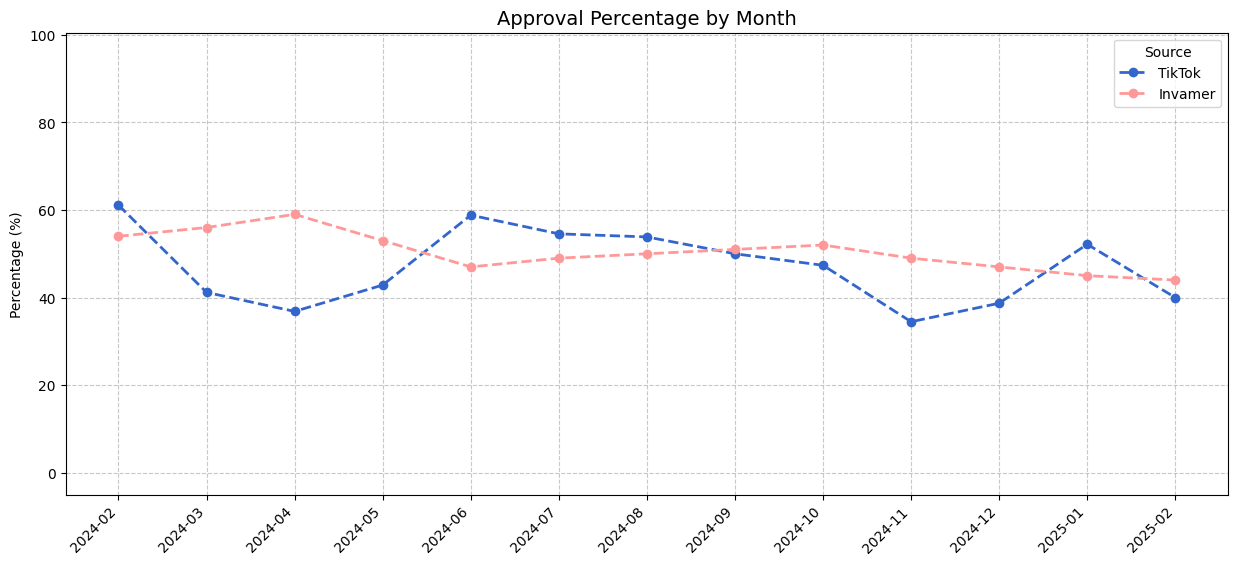

In [49]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))

x_data = range(len(invamer_data['date']))

ax1.set_title('Approval Percentage by Month', fontsize=14)
ax1.set_ylabel('Percentage (%)')
ax1.set_xticks(x_data)
ax1.set_xticklabels(invamer_data['date'], rotation=45, ha='right')
ax1.set_ylim(min(df_approval['Approved_percent'])-5, max(df_approval['Approved_percent'])+0.5)
ax1.grid(True, linestyle='--', alpha=0.7)

ax1.plot(x_data, df_approval.loc['2024-02':'2025-02']['Approved_percent'], marker='o', linewidth=2, color='#3366CC', linestyle='--')
ax1.plot(x_data, df_invamer['Approved_percent'], marker='o', linewidth=2, color='#FF9999', linestyle='--')

ax1.legend(['TikTok', 'Invamer'], title='Source')


### Comments reaction to videos topic

In [3]:
df_topics = pd.read_excel(r"results\video_topics_analysis_galan_v2.xlsx", sheet_name='Sheet1', dtype=str)
df_topics['date'] = pd.to_datetime(df_topics['date'])

In [4]:
df_comments_sentiment = pd.read_excel(r"results\comments_sentiment_analysis_galan_v2.xlsx", sheet_name='Sheet1', dtype=str)

In [5]:
display(df_topics)

,main_topic,score,video_id,date
0,security,0.3546099960803986,7374919036544601349,2024-05-30 17:12:32
1,governance,0.163818359375,7274743338903833862,2023-09-03 18:19:39
2,environment,0.3973625600337982,7478350483309088055,2025-03-05 10:39:25
3,water,0.4066950678825378,7428005105493904646,2024-10-20 18:33:43
4,environment,0.5660430192947388,7317679974952045830,2023-12-28 11:15:45
...,...,...,...,...
463,governance,0.2851437330245972,7446961310262152454,2024-12-10 20:33:24
464,subway,0.4315192401409149,7466149899986341142,2025-01-31 13:34:51
465,movility,0.268221378326416,7434626669958188343,2024-11-07 14:48:39
466,movility,0.4692603945732117,7343982099067686150,2024-03-08 08:21:23


In [6]:
display(df_comments_sentiment)

,score,clasification,percentage,date,video_id
0,1,Terrible,0.4978627562522888,2024-05-30 21:24:00,7374919036544601349
1,2,Bad,0.3405648469924927,2024-05-30 17:19:00,7374919036544601349
2,3,Neutral,0.4831511676311493,2024-06-01 12:24:00,7374919036544601349
3,4,Good,0.3938470184803009,2024-05-31 15:27:00,7374919036544601349
4,2,Bad,0.3382949531078339,2024-05-31 07:24:00,7374919036544601349
...,...,...,...,...,...
101313,3,Neutral,0.3769738674163818,2025-03-24 04:02:00,7485171344041053462
101314,4,Good,0.4285002946853638,2025-03-24 00:57:00,7485171344041053462
101315,1,Terrible,0.4074415862560272,2025-03-24 03:30:00,7485171344041053462
101316,1,Terrible,0.6684316992759705,2025-03-25 12:57:00,7485171344041053462


In [7]:
merged_df = pd.merge(df_comments_sentiment, df_topics, on='video_id', how='inner')

In [ ]:
# Rename the columns
merged_df = merged_df.rename(columns={
    'score_x': 'score',
    'clasification': 'clasification',
    'date_x': 'date',
    'video_id': 'video_id',
    'main_topic': 'main_topic',
})

# Drop the unwanted columns from the DataFrame (not the columns Index)
merged_df = merged_df.drop(columns=['score_y', 'date_y','percentage'])

# Convert the 'date' column to datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

: 

: 

: 

In [8]:
display(merged_df)

,score_x,clasification,percentage,date_x,video_id,main_topic,score_y,date_y
0,1,Terrible,0.4978627562522888,2024-05-30 21:24:00,7374919036544601349,security,0.3546099960803986,2024-05-30 17:12:32
1,2,Bad,0.3405648469924927,2024-05-30 17:19:00,7374919036544601349,security,0.3546099960803986,2024-05-30 17:12:32
2,3,Neutral,0.4831511676311493,2024-06-01 12:24:00,7374919036544601349,security,0.3546099960803986,2024-05-30 17:12:32
3,4,Good,0.3938470184803009,2024-05-31 15:27:00,7374919036544601349,security,0.3546099960803986,2024-05-30 17:12:32
4,2,Bad,0.3382949531078339,2024-05-31 07:24:00,7374919036544601349,security,0.3546099960803986,2024-05-30 17:12:32
...,...,...,...,...,...,...,...,...
86236,3,Neutral,0.3769738674163818,2025-03-24 04:02:00,7485171344041053462,movility,0.2750244140625,2025-03-23 19:47:57
86237,4,Good,0.4285002946853638,2025-03-24 00:57:00,7485171344041053462,movility,0.2750244140625,2025-03-23 19:47:57
86238,1,Terrible,0.4074415862560272,2025-03-24 03:30:00,7485171344041053462,movility,0.2750244140625,2025-03-23 19:47:57
86239,1,Terrible,0.6684316992759705,2025-03-25 12:57:00,7485171344041053462,movility,0.2750244140625,2025-03-23 19:47:57


In [12]:
# Group by main_topic and calculate the required metrics
topic_summary = merged_df.groupby('main_topic').agg(
    average_score=('score', lambda x: pd.to_numeric(x, errors='coerce').mean()),
    total_videos=('video_id', 'nunique'),
    total_comments=('video_id', 'count')
).reset_index()

In [13]:
display(topic_summary.head(20))

,main_topic,average_score,total_videos,total_comments
0,environment,2.553808,19,4451
1,governance,2.657990,110,18979
2,infrastructure,2.683429,32,7816
3,movility,2.796916,167,29958
4,security,3.113636,52,8052
5,subway,2.623742,26,5265
6,urban planning,2.407143,2,420
7,water,2.360354,41,11300


<Axes: title={'center': 'Average Score by Main Topic'}, xlabel='Main Topic', ylabel='Average Score'>

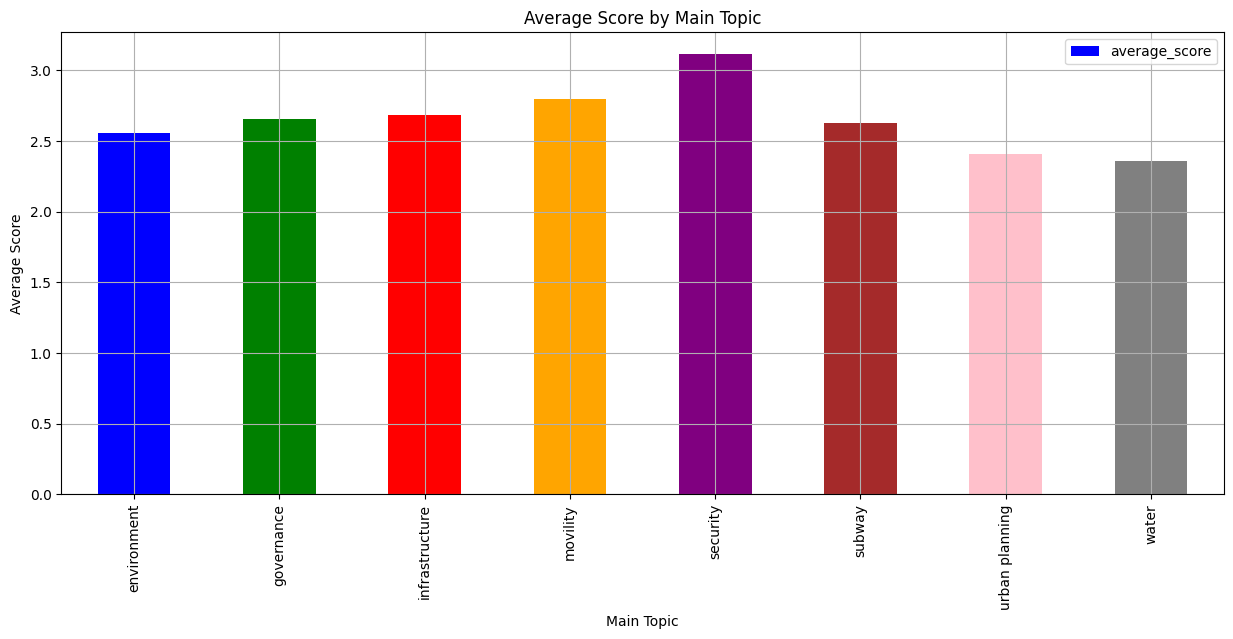

In [14]:
topic_summary.plot.bar(x='main_topic',
                       y='average_score',
                       figsize=(15, 6),
                       title='Average Score by Main Topic',
                       xlabel='Main Topic',
                       ylabel='Average Score',
                       color=['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'yellow', 'lime', 'teal', 'navy'],
                       grid=True
                    )